In the last chapter we used a classification head to finetune our llm to classify statements into spam or non-spam, now we will finetune it to follow instructions and provide responses accordingly. For that we need a dataset, then load the model with that dataset and train it. Firstly i am training the same way it is given in the module, then later on i will train 

In [1]:
#imports 

import json
import os
import urllib
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset

In [2]:
def load_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file :
        data = json.load(file)
        
    return data

file_path = "instruction-data.json"
data = load_file(file_path)
len(data)

1100

In [3]:
print(data[30])
print(data[31])
print(data[40])

{'instruction': 'Alter the content of the sentence to use the past tense.', 'input': 'The ship sails at dawn.', 'output': 'The ship sailed at dawn.'}
{'instruction': "Generate a sentence that follows the pattern: 'Rarely do I _____'", 'input': '', 'output': 'Rarely do I eat fast food.'}
{'instruction': "Generate a sentence using the word 'gregarious'.", 'input': '', 'output': 'He was gregarious, making friends wherever he went.'}


In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [5]:
model_input = format_input(data[30])
desired_response = f"\n\n###Response :\n{data[30]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Alter the content of the sentence to use the past tense.

### Input:
The ship sails at dawn.

###Response :
The ship sailed at dawn.


In [6]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.10)

train_data = data[:train_portion]
test_data = data[train_portion:test_portion+train_portion]
val_data = data[test_portion + train_portion:]

print(len(train_data), len(test_data), len(val_data))

935 110 55


Now to batch this data, we will format the data using prompt template then tokenize the formatted data, followed by padding to adjust the same size, creating target token ids for training and replace the padding tokens with place holders.

In [7]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [8]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

For the padding, we will not decide a maximum length for all the batches and tokens, instead we can create a custom collate function which pads the training examples in each batch to have the same length but different batches can have different lengths, this way there won't be unnecessary long examples for all the batches.

In [9]:
def custom_collate_draft1(batch, pad_token_id = 50256, device = "cpu"):
    batch_max = max(len(item)+1 for item in batch)
    inputs_list = []
    for item in batch :
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * (batch_max - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        inputs_list.append(inputs)
    
    inputs_tensor = torch.stack(inputs_list).to(device)
    return inputs_tensor


In [10]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


The highest input length was 5, so for inputs 2 and 3 padded tokens were added to make the length equal to 5, but for a different batch whose max length would be 4 then it would be only padded to 4. For the training of an LLM we need shfited tokens too, so we add that and also add an ignore_index parameter to replace all the padding tokens with a new value so that these tokens are ignored by the loss function.

In [11]:
def custom_collate_fxn(batch, pad_token_id = 50256, ignore_index = -100, allowed_max_length = None, device = "cpu"):
    batch_max = max(len(item)+1 for item in batch)
    inputs_list, targets_list = [], []
    for item in batch :
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_list.append(inputs)
        targets_list.append(targets)

    inputs_tensor = torch.stack(inputs_list).to(device)
    targets_tensor = torch.stack(targets_list).to(device)

    return inputs_tensor, targets_tensor

In [12]:
inputs, targets = custom_collate_fxn(batch)

print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [13]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [14]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [15]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


What we see here, adding of -100 token to the targets doesn't change the loss this is because in the internal structure of cross entropy toekns with -100 value are ignored for the loss calculation. So, for the first padding token we use 50256 just to indicate that the sequence has ended and then all the tokens are -100 so that their loss isn't counted. 

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
from functools import partial

customized_collate_fxn = partial(
    custom_collate_fxn,
    device=device,
    allowed_max_length=1024
)

In [18]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fxn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fxn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fxn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [19]:
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.Size([8, 68])


In [20]:
print(inputs[0])
print(targets[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')
tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   3

Now we will load the pretrained gpt2 model , but this time we are going to load the medium sized model.

In [21]:
from gpt_download import download_and_load_gpt2
from important_GPT_blocks import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/home/salaj/anaconda3/envs/dl-env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [22]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [23]:
def generate(model, idx, max_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  
            idx_next = torch.multinomial(probs, num_samples=1) 

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) 
            
        if idx_next == eos_id:  
            break
        idx = torch.cat((idx, idx_next), dim=1) 

    return idx

In [24]:
from add_training_data import text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [25]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The following is a list of the following:

The first time I was in the kitchen of my first job. I was a little surprised to see that the


In [26]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] 
    target_batch = target_batch[:, -1]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [27]:
from add_training_data import train_model_simple

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    
print(train_loss)
print(val_loss)

4.529736948013306
4.704107332229614


In [28]:

torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [29]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000115): Train loss 0.604, Val loss 0.818
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The chef cooks the meal every day.<|endoftext|>The following is an excerpt from 'The Great Gatsby': A History of the United States of America.'  The Great Gatsby The Great Gatsby
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef cooks the meal every day.'  ### Response: The meal every day is cooked by the chef.<|endoftext|>The following is an excerpt from 'The Great Gatsby': The Great Gatsby  The Great Gatsby The Great Gatsby The
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Convert the active sentence to passive: 'The chef

I tried to train the gpt medium model but the Cuda storage it needs exceed 4.5 gb or so, my gpu only has 3.8 GB VRAM so it is not possible. I tried using different parameters like batch size 1, tweaking the optimizer and etc but nothing works, so i need to train it on the gpt small itself. Later i might try to use the google colab to train medium or maybe large but as far as this project goes, i will train only the gpt small.

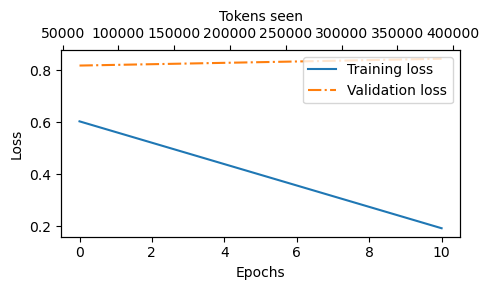

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  
    
    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [33]:
torch.manual_seed(123)


for entry in test_data[:10]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is cirrus.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Pr

THe model is performing well, however it is still making some errors. In the code implemented in the book, the word cumulonimbus may have come up in the training of the gpt medium but the gpt small may not know the usage, there i think it went bad. I will try some of my own questions to test it.

In [34]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-small124M-sft.pth
